# Toy Example

## Settings for i.i.d case

\begin{align}
    S_{0}&\sim Bernoulli(0.5)\\
    M_{t}&\sim Bernoulli(expit(1.0-1.5S_{t}+2.5A_{t}))\\
    R_{t}&\sim Bernoulli(expit(1.0+2S_{t}-1A_{t}-2.5M_{t}))\\
    S_{t+1}&\sim Bernoulli(.2)\\
    \pi_{b}&\sim Bernoulli(expit(1.0-2.0S{t}))\\
    \pi_{e}&\sim Bernoulli(expit(1.5+1.0S{t}))\\
    a_0&=0
\end{align}

In [5]:
        from scipy.special import expit
        pa = 1.0-2
        #pa = 1.0
        pa = expit(pa)
        pa

0.2689414213699951

## True Q & True etas

In [1]:
def target_policy(state, action = None, matrix_based = False):
    if matrix_based:
        state1 = np.copy(state).flatten()
        pa = expit(1.5 + 1.0 * state1)
        if action is not None:
            action1 = np.copy(action).flatten()
            pa = pa * action1 + (1-pa) * (1-action1)
    else:
        pa = 1.5 + 1.0 * np.sum(state)
        pa = expit(pa)
        pa = np.random.binomial(n=1, p=pa, size=1)
    return pa
    
def toy_sa2mediator_model(state, action, matrix_based = False):
    if matrix_based:
        state1 = np.copy(state).flatten()
        action1 = np.copy(action).flatten()
        pm =  1.0 - 1.5 * state1 + 2.5 * action1
        pm = expit(pm)
    else:
        pm = 1.0 - 1.5 * state + 2.5 * action
        pm = expit(pm)
        pm = np.random.binomial(n=1, p=pm, size=1)
    return pm

def pmlearner(state, action, mediator):
    pm_one = toy_sa2mediator_model(state, action=action, matrix_based = True).flatten() 
    pm = mediator * pm_one + (1 - mediator) * (1 - pm_one)
    return pm

def control_policy(state = None, action=None, get_a = False, matrix_based=False):
    # fixed policy with fixed action 0
    if get_a:
        action_value = 0
        
    elif matrix_based:
        action1 = np.copy(action).flatten()
        action_value = 1 - action1 ###for a0 = 0 only
        
    else:
        if action is None:
            action_value = 0 
        else:
            if action == 0:
                action_value = 1
            else:
                action_value = 0
    return action_value

def toy_sam2reward_model(state, action, mediator, random = None, matrix_based = False):
        if matrix_based:
            #print("matrix")
            state1 = np.copy(state).flatten()
            action1 = np.copy(action).flatten()
            mediator1 = np.copy(mediator).flatten()
            rmean = 1.0 + 2 * state1 - 1 * action1 -  2.5 * mediator1
            #rmean = 1.0 * np.ones(shape = state1.shape[0])
            rmean = expit(rmean)
            if random is None:
                rmean *= 10
                reward = rmean
            else:
                print("wrong")
        else:
            rmean = 1.0 + 2 * state - 1 * action -  2.5 * mediator
            #rmean = 1.0
            rmean = expit(rmean)
            if random:
                reward = np.random.binomial(n=1, p=rmean, size=1) * 10
            else:
                rmean *= 10
                reward = rmean
        return reward

In [2]:
###true without estimating etas
from tqdm import tqdm
import pickle
import numpy as np
from scipy.special import expit
from multiprocessing import Pool
import Policy as policy
import Simulator as Simulator
import pandas as pd
from qLearner_MC import Qlearner as Qlearner_MC
def learnQ(Qlearner, simulator, traj,target_policy, control_policy, toy_sam2reward_model, true_etas=None):
    q1 = Qlearner(traj, simulator, target_policy, pmlearner, toy_sam2reward_model, control_policy, Q_func = "Q1", true_etas=true_etas)
    b_hat1 = q1.fit()
    
    q2 = Qlearner(traj, simulator, target_policy, pmlearner, toy_sam2reward_model, control_policy, Q_func = "Q2", true_etas=true_etas)
    b_hat2 = q2.fit()
    
    q3 = Qlearner(traj, simulator, target_policy, pmlearner, toy_sam2reward_model, control_policy, Q_func = "Q3",true_etas=true_etas)
    b_hat3 = q3.fit()
    
    #traj1 = simulator.sample_target_policy_trajectory(num_trajectory=num_trajectory, num_time=num_time,
    #                                                 seed=seed, policy = "control", burn_in=False, return_trajectory=True)
    #traj1 = simulator.trajectory2iid(trajectory = traj1)
    
    q4 = Qlearner(traj, simulator, control_policy, pmlearner, toy_sam2reward_model, control_policy, Q_func = "Q4",true_etas=true_etas)
    b_hat4 = q4.fit()
    out = {'b_hat1':b_hat1, 'b_hat2':b_hat2, 'b_hat3':b_hat3,'b_hat4':b_hat4, 'q1':q1, 'q2':q2, 'q3':q3,'q4':q4}
    return out

simulator = Simulator.Simulator(dim_state=1, model_type='toy_iid')
traj = simulator.sample_trajectory(num_trajectory=200, num_time=200,
                                                     seed=10, burn_in=False, return_trajectory=True)
traj = simulator.trajectory2iid(trajectory = traj)

out1 = learnQ(Qlearner_MC, simulator, traj, target_policy, control_policy, toy_sam2reward_model)
#out2 = learnQ(Qlearner2, target_policy, control_policy, toy_sam2reward_model)

out = []
for b in ['b_hat1','b_hat2','b_hat3','b_hat4']:
    out.append(out1[b])

In [3]:
out = pd.DataFrame(out,index = ['Q1','Q2','Q3','Q4'])
out

,0,1,2,3,4,5,6,7
Q1,2.215155,-2.310586e+00,-5.486331e+00,1.497385,-1.085992,-6.552004e+00,-3.535179,1.993334
Q2,2.215155,1.442402e-12,-5.486331e+00,2.215155,-1.085992,-5.486331e+00,-1.085992,3.128748
Q3,4.979667,-4.796163e-12,-4.831691e-12,4.979667,4.979667,-4.583001e-12,4.979667,4.295690
Q4,2.215155,-2.310586e+00,-5.486331e+00,1.497385,-1.085992,-6.552004e+00,-3.535179,4.295690


In [4]:
out.iloc[:,-1].to_numpy()

array([1.99333432, 3.12874809, 4.29569015, 4.29569015])

## True DE/ME/SE

In [5]:
    true_eta_pi = 1.99333432
    true_eta_pi_a0 = 3.12874809
    true_eta_pi_a0star = 4.29569015
    true_eta_a0 = 4.29569015
    DE = true_eta_pi - true_eta_pi_a0
    ME = true_eta_pi_a0 - true_eta_pi_a0star
    SE = true_eta_pi_a0star - true_eta_a0
    DE,ME,SE

(-1.1354137700000002, -1.1669420600000002, 0.0)

## Robustness

In [53]:
import pickle
with open("Toy_2_iid.txt", 'rb') as p:
    Error_iid = pickle.load(p)
with open("Toy_2_w_state.txt", 'rb') as p:
    Error_w_state = pickle.load(p)

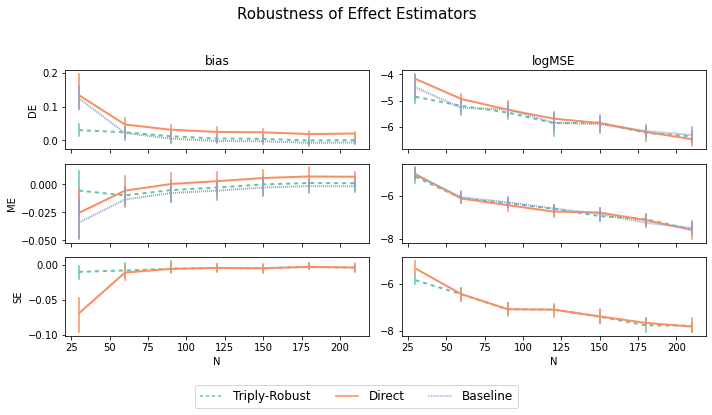

DE_error  ME_error  SE_error    DE_MSE    ME_MSE  \
N     estimand                                                          
30.0  Baseline       0.124892 -0.034148       NaN -4.489622 -5.031311   
      Direct         0.134679 -0.025382 -0.068996 -4.168050 -4.990100   
      Triply-Robust  0.030509 -0.005495 -0.009700 -4.845704 -5.107380   
60.0  Baseline       0.022144 -0.013484       NaN -5.269360 -6.056846   
      Direct         0.047272 -0.005541 -0.010721 -4.929473 -6.124107   
      Triply-Robust  0.023985 -0.009779 -0.007660 -5.191489 -6.115741   
90.0  Baseline       0.005165 -0.007681       NaN -5.318976 -6.303325   
      Direct         0.031702  0.000442 -0.005485 -5.334044 -6.430935   
      Triply-Robust  0.012260 -0.005031 -0.005295 -5.442717 -6.334522   
120.0 Baseline      -0.001814 -0.005528       NaN -5.829371 -6.586900   
      Direct         0.025160  0.002931 -0.004071 -5.675993 -6.731449   
      Triply-Robust  0.005499 -0.002736 -0.004083 -5.842865 -6.600965   
150.0 Baseline      -0.002663 -0.002716       NaN -5.887200 -6.839712   
      Direct         0.023951  0.005742 -0.004609 -5.840293 -6.772328   
      Triply-Robust  0.004572  0.000029 -0.004539 -5.827158 -6.940215   
180.0 Baseline      -0.007445 -0.001491       NaN -6.144353 -7.248157   
      Direct         0.018812  0.007133 -0.002554 -6.180280 -7.129698   
      Triply-Robust -0.000364  0.001281 -0.002534 -6.213104 -7.083828   
210.0 Baseline      -0.006232 -0.001687       NaN -6.295008 -7.491671   
      Direct         0.020342  0.006877 -0.003632 -6.455446 -7.582426   
      Triply-Robust  0.000939  0.001080 -0.003632 -6.347563 -7.561561   

                       SE_MSE  
N     estimand                 
30.0  Baseline            NaN  
      Direct        -5.348641  
      Triply-Robust -5.848129  
60.0  Baseline            NaN  
      Direct        -6.446796  
      Triply-Robust -6.450390  
90.0  Baseline            NaN  
      Direct        -7.085237  
      Triply-Robust -7.102036  
120.0 Baseline            NaN  
      Direct        -7.107893  
      Triply-Robust -7.104144  
150.0 Baseline            NaN  
      Direct        -7.395420  
      Triply-Robust -7.412639  
180.0 Baseline            NaN  
      Direct        -7.675287  
      Triply-Robust -7.774395  
210.0 Baseline            NaN  
      Direct        -7.831146  
      Triply-Robust -7.799210

In [54]:
from plot import plot, summary
import numpy as np
result = summary(Error_iid, N_range = np.arange(1, 8) * 30, T_range = [50], absolute = False)
fig = plot(result,x='N')
result.groupby(['N','estimand']).mean()[['DE_error','ME_error','SE_error','DE_MSE','ME_MSE','SE_MSE']]


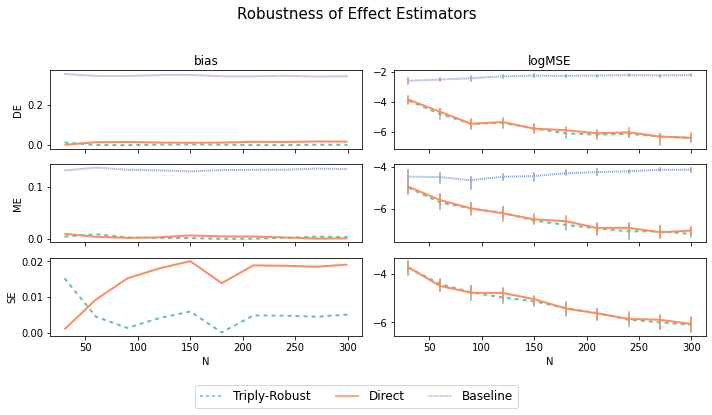

DE_error  ME_error  SE_error    DE_MSE    ME_MSE  \
N     estimand                                                          
30.0  Baseline       0.350748  0.131482       NaN -2.595198 -4.455423   
      Direct         0.002191  0.009837  0.001017 -3.849765 -4.931263   
      Triply-Robust  0.013921  0.004412  0.015291 -3.914252 -4.974018   
60.0  Baseline       0.340971  0.137126       NaN -2.522556 -4.477341   
      Direct         0.014954  0.004149  0.009341 -4.651175 -5.559713   
      Triply-Robust  0.001158  0.009070  0.004536 -4.788514 -5.673791   
90.0  Baseline       0.340452  0.132915       NaN -2.426134 -4.626756   
      Direct         0.016149  0.002038  0.015258 -5.456078 -5.966221   
      Triply-Robust  0.000019  0.002979  0.001399 -5.462188 -5.971554   
120.0 Baseline       0.345303  0.131787       NaN -2.304894 -4.458538   
      Direct         0.013276  0.003014  0.018018 -5.342318 -6.192400   
      Triply-Robust  0.002927  0.001982  0.004103 -5.389877 -6.170006   
150.0 Baseline       0.346393  0.129836       NaN -2.260592 -4.430907   
      Direct         0.012173  0.006827  0.020071 -5.779453 -6.482811   
      Triply-Robust  0.004039  0.001726  0.005995 -5.774982 -6.542294   
180.0 Baseline       0.339345  0.132330       NaN -2.273038 -4.295352   
      Direct         0.013203  0.004926  0.013912 -5.879860 -6.567484   
      Triply-Robust  0.002724  0.000210  0.000138 -6.090825 -6.745340   
210.0 Baseline       0.339034  0.132638       NaN -2.250619 -4.241709   
      Direct         0.016656  0.004598  0.018892 -6.089435 -6.888226   
      Triply-Robust  0.000579  0.000526  0.004872 -6.175702 -6.906318   
240.0 Baseline       0.341741  0.132872       NaN -2.219274 -4.197968   
      Direct         0.015948  0.002923  0.018791 -6.022512 -6.880701   
      Triply-Robust  0.000207  0.002114  0.004838 -6.125709 -7.049831   
270.0 Baseline       0.337763  0.135150       NaN -2.239657 -4.132870   
      Direct         0.018478  0.000698  0.018516 -6.306235 -7.093674   
      Triply-Robust  0.002385  0.004343  0.004535 -6.301312 -7.051017   
300.0 Baseline       0.339815  0.134199       NaN -2.216870 -4.129810   
      Direct         0.017871  0.001312  0.019118 -6.385811 -7.012859   
      Triply-Robust  0.001704  0.003709  0.005130 -6.410925 -7.175535   

                       SE_MSE  
N     estimand                 
30.0  Baseline            NaN  
      Direct        -3.711423  
      Triply-Robust -3.722250  
60.0  Baseline            NaN  
      Direct        -4.480500  
      Triply-Robust -4.404200  
90.0  Baseline            NaN  
      Direct        -4.767929  
      Triply-Robust -4.749856  
120.0 Baseline            NaN  
      Direct        -4.774293  
      Triply-Robust -4.963577  
150.0 Baseline            NaN  
      Direct        -5.033012  
      Triply-Robust -5.122045  
180.0 Baseline            NaN  
      Direct        -5.421521  
      Triply-Robust -5.399914  
210.0 Baseline            NaN  
      Direct        -5.620749  
      Triply-Robust -5.614587  
240.0 Baseline            NaN  
      Direct        -5.852442  
      Triply-Robust -5.886627  
270.0 Baseline            NaN  
      Direct        -5.889251  
      Triply-Robust -5.994300  
300.0 Baseline            NaN  
      Direct        -6.064405  
      Triply-Robust -6.105595

In [55]:
#from plot import plot, summary
import numpy as np
result = summary(Error_w_state, N_range = np.arange(1, 11) * 30, T_range = [50])
fig = plot(result,x='N')
result.groupby(['N','estimand']).mean()[['DE_error','ME_error','SE_error','DE_MSE','ME_MSE','SE_MSE']]


In [74]:
from matplotlib.transforms import BlendedGenericTransform
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot(result_iid, result_w_state, x='NT'):
    fig, ((ax1, ax2, ax3, ax4) ,(ax5, ax6,ax7,ax8)) = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=False, figsize = (10,5))

    COLORS = sns.color_palette("colorblind")
    palette = {'Triply-Robust' : COLORS[0],'Direct' : COLORS[1], 'Baseline': COLORS[4]}
    style = {'Triply-Robust' : (1,1),'Direct' : (1,0), 'Baseline': (2,2)}

    ax1 = sns.lineplot(data=result_iid
                         , x=x, y="DE_error"
                         , hue="estimand" # group variable
                       , style="estimand" 
                        , ci = 95
                        , err_style="bars"
                        , ax = ax1
                        , n_boot = 20
                        , palette = palette
                       ,dashes=style
                       ,linewidth = 2.0,
                       markers = True
                        )
    ax1.set_title('DE (iid)')
    ax1.axes.set_ylabel("bias")
    
    ax2 = sns.lineplot(data=result_iid
                         , x=x, y="ME_error"
                         , hue="estimand" # group variable
                       , style="estimand" 
                        , ci = 95
                        , err_style="bars"
                        , ax = ax2
                        , n_boot = 20
                        , palette = palette
                       ,dashes=style
                       ,linewidth = 2.0,
                       markers = True
                        )
    ax2.set_title('ME (iid)')
    ax2.set(ylabel=None)
    
    ax3 = sns.lineplot(data=result_w_state
                         , x=x, y="DE_error"
                         , hue="estimand" # group variable
                       , style="estimand" 
                        , ci = 95
                        , err_style="bars"
                        , ax = ax3
                        , n_boot = 20
                        , palette = palette
                       ,dashes=style
                       ,linewidth = 2.0,
                       markers = True
                        )
    ax3.set_title('DE (with State Transition)')
    ax3.set(ylabel=None)
    
    ax4 = sns.lineplot(data=result_w_state
                         , x=x, y="ME_error"
                         , hue="estimand" # group variable
                       , style="estimand" 
                        , ci = 95
                        , err_style="bars"
                        , ax = ax4
                        , n_boot = 20
                        , palette = palette
                       ,dashes=style
                       ,linewidth = 2.0,
                       markers = True
                        )
    ax4.set_title('ME (with State Transition)')
    ax4.set(ylabel=None)
    
    ax5 = sns.lineplot(data=result_iid
                         , x=x, y="DE_MSE"
                         , hue="estimand" # group variable
                       , style="estimand" 
                        , ci = 95
                        , err_style="bars"
                        , ax = ax5
                        , n_boot = 20
                        , palette = palette
                       ,dashes=style
                       ,linewidth = 2.0,
                       markers = True
                        )
    ax5.axes.set_ylabel("logMSE")


    ax6 = sns.lineplot(data=result_iid
                         , x=x, y="ME_MSE"
                         , hue="estimand" # group variable
                        , style="estimand" 
                        , ci = 95
                        , err_style="bars"
                        , ax = ax6
                        , n_boot = 20
                        , palette = palette
                       ,dashes=style
                       ,linewidth = 2.0,
                       markers = True
                        )
    ax6.set(ylabel=None)
    
    
    ax7 = sns.lineplot(data=result_w_state
                         , x=x, y="DE_MSE"
                         , hue="estimand" # group variable
                       , style="estimand" 
                        , ci = 95
                        , err_style="bars"
                        , ax = ax7
                        , n_boot = 20
                        , palette = palette
                       ,dashes=style
                       ,linewidth = 2.0,
                       markers = True
                        )
    ax7.set(ylabel=None)


    ax8 = sns.lineplot(data=result_w_state
                         , x=x, y="ME_MSE"
                         , hue="estimand" # group variable
                        , style="estimand" 
                        , ci = 95
                        , err_style="bars"
                        , ax = ax8
                        , n_boot = 20
                        , palette = palette
                       ,dashes=style
                       ,linewidth = 2.0,
                       markers = True
                        )
    ax8.set(ylabel=None)

    handles, labels = ax1.get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc='lower center', ncol = len(labels)
                           , bbox_to_anchor=(0.5, -0.1), bbox_transform=fig.transFigure,fontsize = 15)
    ax1.get_legend().remove()
    ax2.get_legend().remove()
    ax3.get_legend().remove()
    ax4.get_legend().remove()
    ax5.get_legend().remove()
    ax6.get_legend().remove()
    ax7.get_legend().remove()
    ax8.get_legend().remove()
    plt.tight_layout()
    plt.show()    
    fig.savefig('toy_2', bbox_inches='tight')

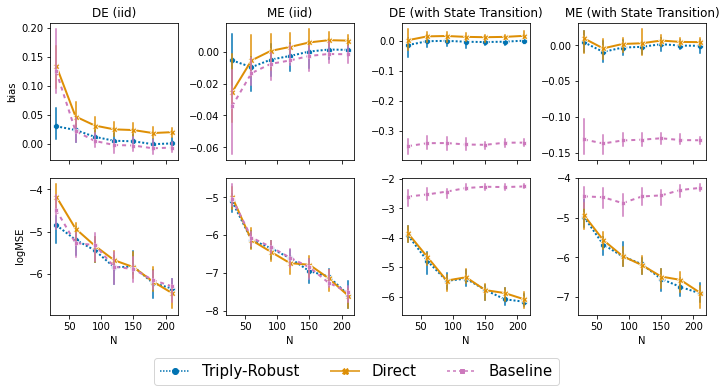

In [75]:
result_iid = summary(Error_iid, N_range = np.arange(1, 8) * 30, T_range = [50], absolute = False)
result_w_state = summary(Error_w_state, N_range = np.arange(1, 8) * 30, T_range = [50], absolute = False)

fig = plot(result_iid,result_w_state,x='N')